# Titanic dataset analysis and Model Training

##### Welcome to this Jupyter notebook, where we will explore the Titanic dataset and build predictive models to analyze passenger survival. 
##### This notebook is designed to guide you through the process of data analysis, feature engineering, and model training, providing insights
##### into the factors that influenced survival rates on the Titanic.

# 1. Initial Analytics

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
### Load the dataset and set the passanger index as the dataframe index
dataset = pd.read_csv("titanic\\train.csv", index_col ="PassengerId")

In [3]:
dataset.head(4)

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S

In [4]:
dataset.keys()

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Intial Visualisations

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Let's start by seeing what data is missing?

In [6]:
dataset.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

We can see that we are missing a lot of age data, a lot of Cabin data and and a small number of embarked data. 

Let's take a closer look at these variables

### Gender

Let's start with Gender:

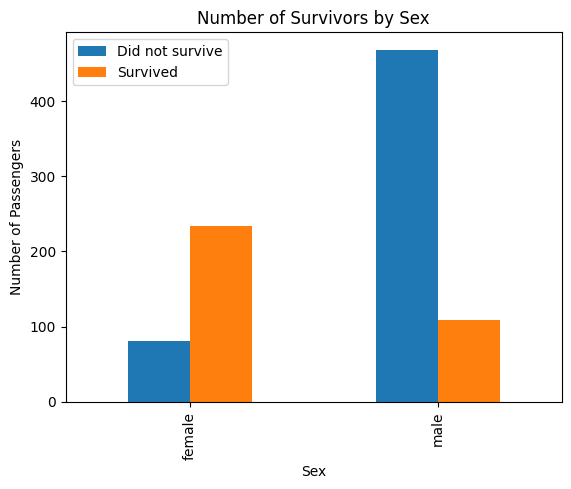

In [7]:
dataset.groupby(['Sex', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Sex')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by Sex')
plt.legend(['Did not survive', 'Survived'])
plt.show()

We can see that A lot more Female passangers survived than male passangers, and at a much higher proportion. This makes sense as protocol dictated that women and children should be saved first

### Class

Below we show how class impacted survivability. Here we can also see that much more passangers survived from first and second class than did from third class. This makes sense as first class passangers were know to be boarded first into lifeboats followed by the second and third class passangers. 

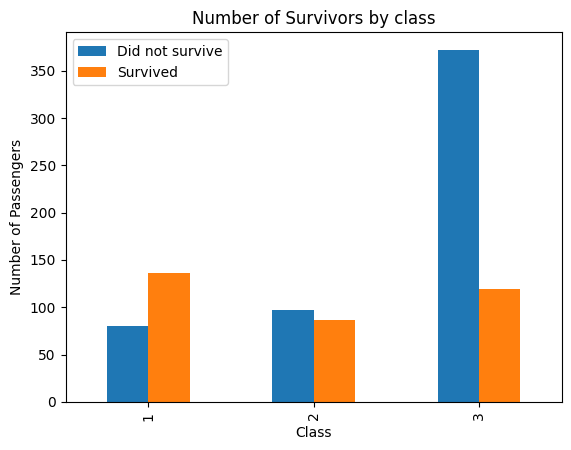

In [8]:
dataset.groupby(['Pclass', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Class')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by class')
plt.legend(['Did not survive', 'Survived'])
plt.show()

### Siblings and spouse

The SibSp column refers to the number of people with a sibling or spouse with them. This is a way to tell if someone had family. As we can see below those with no siblings or spouse had a far lower survival chance than those with 1 or more siblings/spouse, though very few people on board had more than 1 SibSp. 

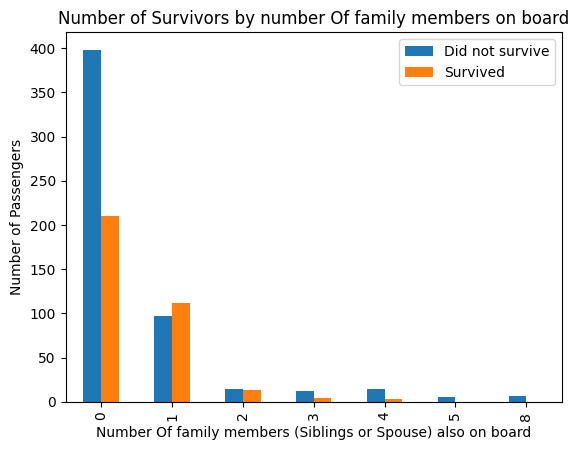

In [9]:
dataset.groupby(['SibSp', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Number Of family members (Siblings or Spouse) also on board')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by number Of family members on board')
plt.legend(['Did not survive', 'Survived'])
plt.show()

### Embarkment point

We can also investigate if there is any relationship on where the individual embarked Titanic. The Values in this column are categorical and refer to the following locations:



| Letter       | Location |
|-------------|----------|
| C | Cherbourg, France      |
| Q| Queenstown (now Cobh), Ireland      |
| S | Southampton, England     |


and we can see that there are some corelations with Embarkment point and survival, with those boarding in Cherbourg having a higher likelyhood of survival than those who boarded in Queenstown or in Southampton

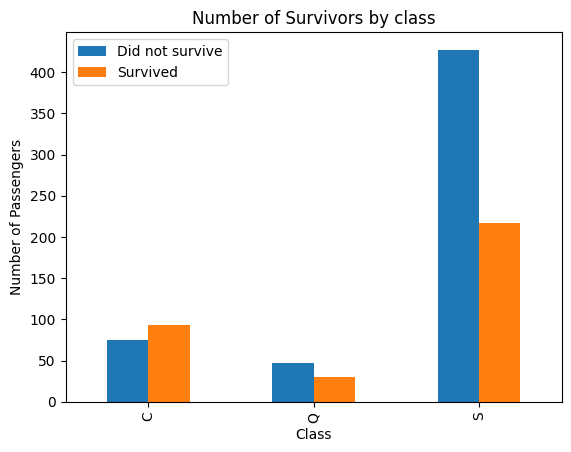

In [10]:
dataset.groupby(['Embarked', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Class')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by class')
plt.legend(['Did not survive', 'Survived'])
plt.show()

## Fare

Finally we have the passanger fare. Which we can use to create some interesting visualisations of the full dataset

In [11]:
dataset['Pclass'] = dataset['Pclass'].map({1: 'First', 2: 'Second', 3: "Third"})
dataset['Survived'] = dataset['Survived'].map({0: 'Not Survived', 1: 'Survived'})

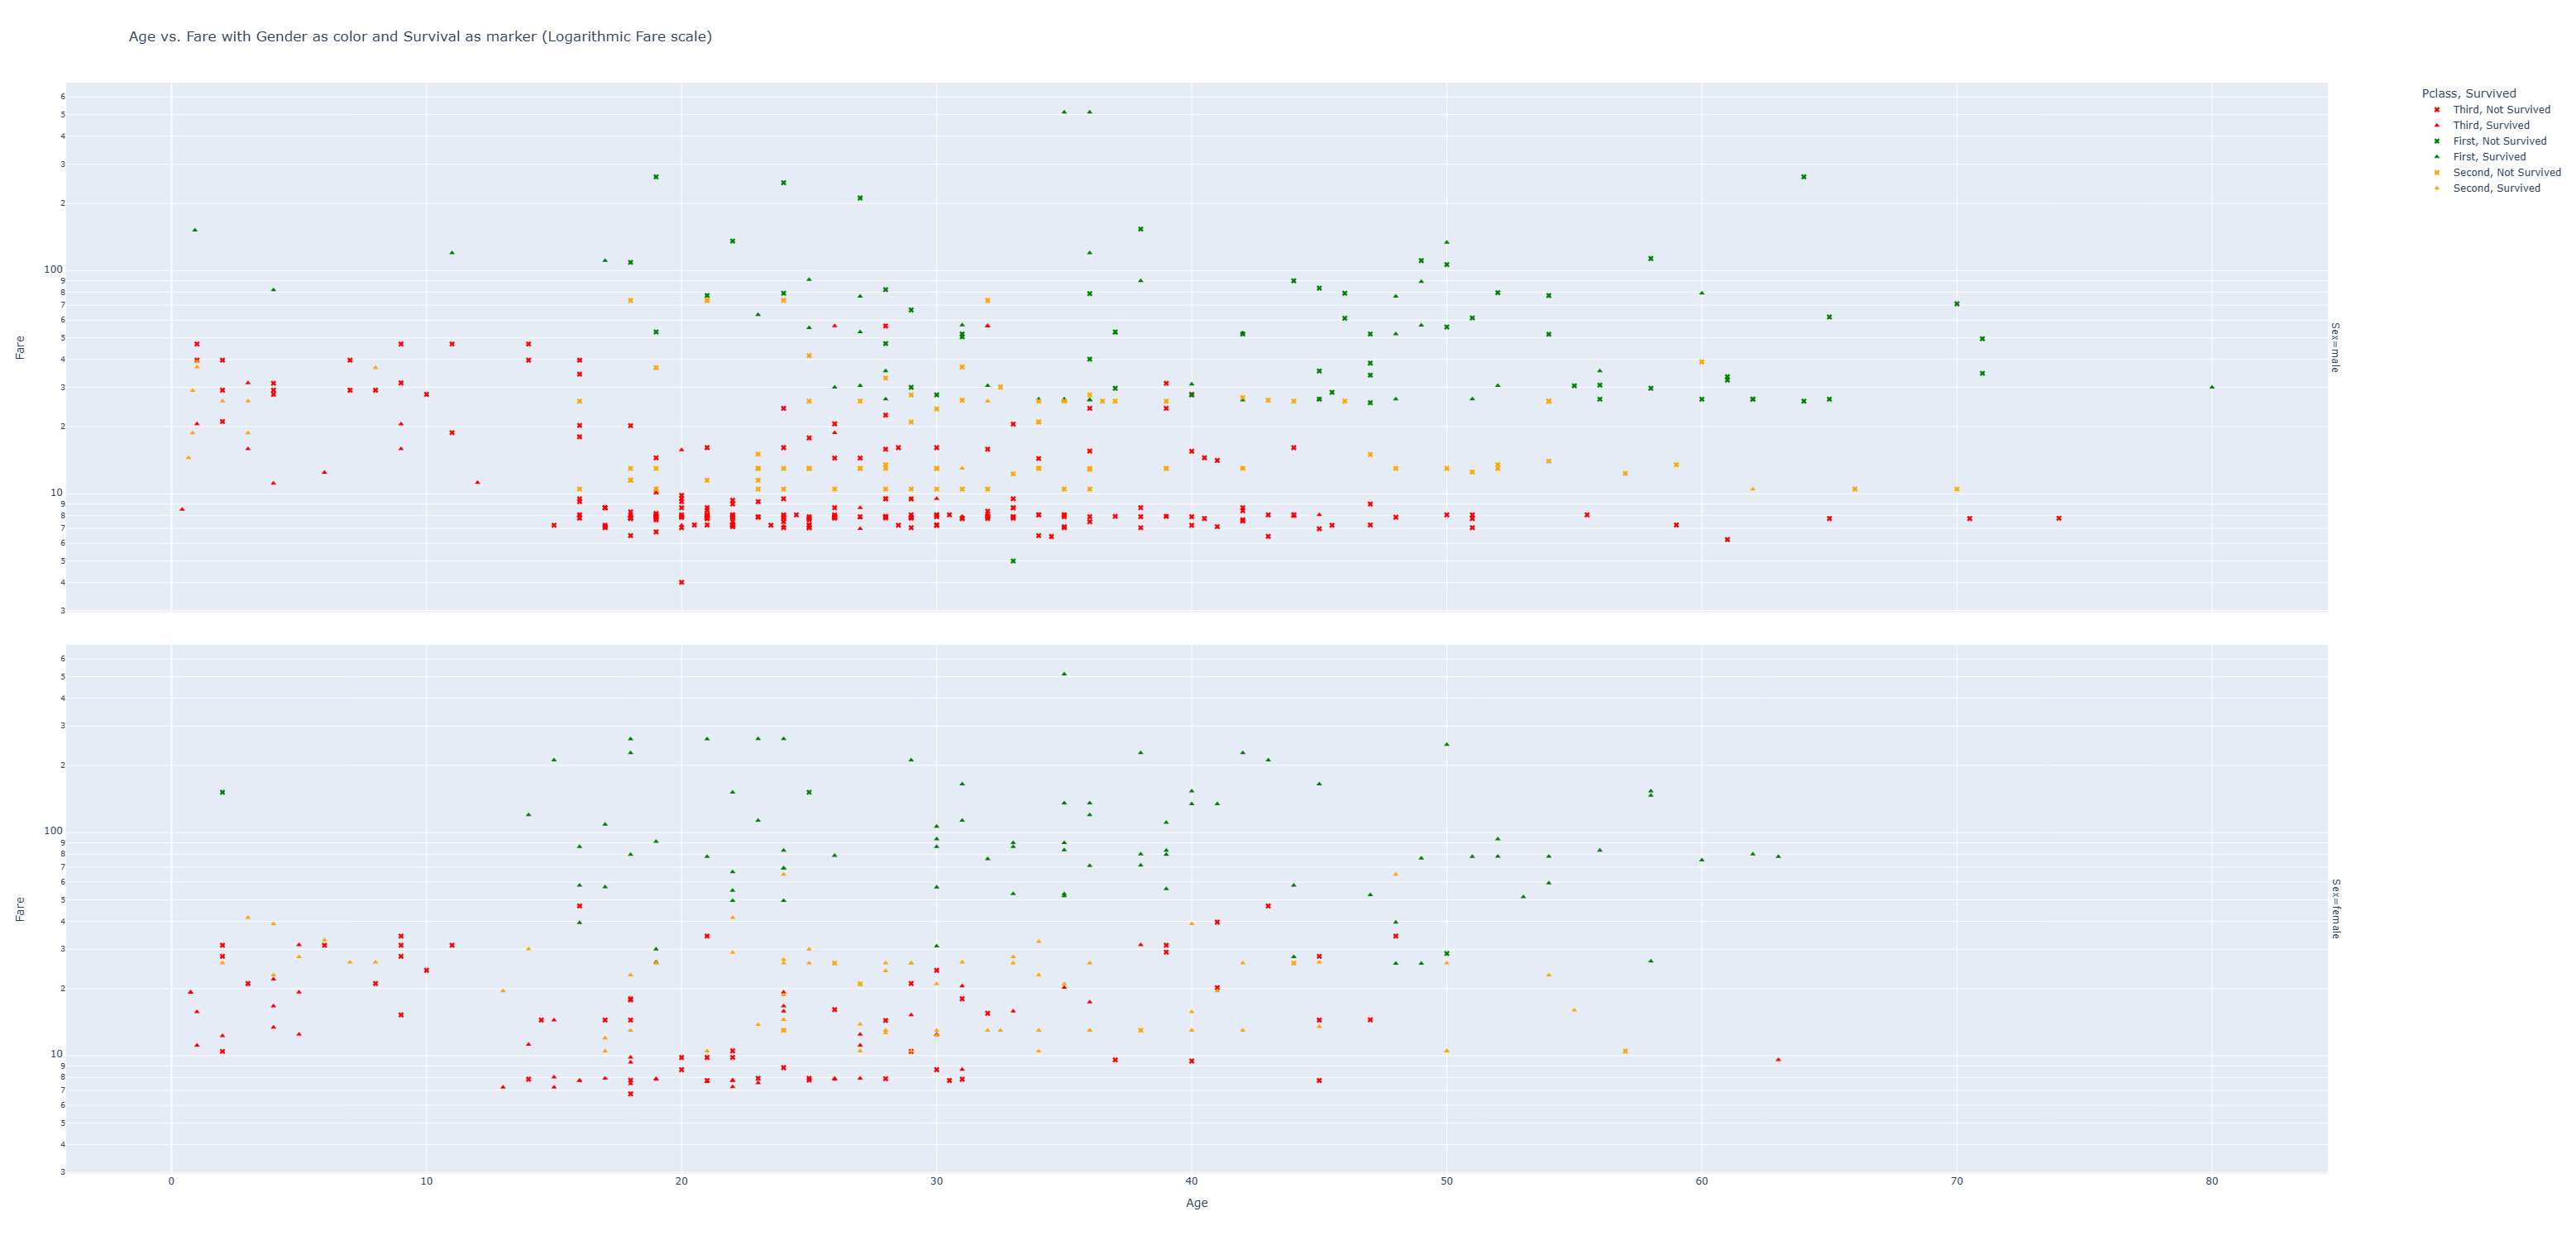

In [12]:
color_map = {'First': 'green', 'Second': 'orange', 'Third': 'red'}
# Create an interactive scatter plot with Plotly
fig = px.scatter(
    dataset,
    x='Age',
    y='Fare',
    color='Pclass',
    color_discrete_map=color_map,
    symbol='Survived',
    symbol_map={'Not Survived': 'x', 'Survived': 'triangle-up'},
    log_y=True,
    title='Age vs. Fare with Gender as color and Survival as marker (Logarithmic Fare scale)',
    labels={'Age': 'Age', 'Fare': 'Fare'},
    hover_data=['Name', 'Pclass', 'Embarked'],
    facet_row='Sex',
#    facet_row = 'SibSp',
    width=3000,
    height=1500
)


# Show the plot
fig.show()


We will do some further work to analyse the Age values later when we do some interpolation of the missing values. 

# 2. Feature Engineering

## Let's take a closer look at the Cabin values

In [13]:
dataset.head(8)

Survived Pclass  \
PassengerId                        
1            Not Survived  Third   
2                Survived  First   
3                Survived  Third   
4                Survived  First   
5            Not Survived  Third   
6            Not Survived  Third   
7            Not Survived  First   
8            Not Survived  Third   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
6                                             Moran, Mr. James    male   NaN   
7                                      McCarthy, Mr. Timothy J    male  54.0   
8                               Palsson, Master. Gosta Leonard    male   2.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S  
6                0      0            330877   8.4583   NaN        Q  
7                0      0             17463  51.8625   E46        S  
8                3      1            349909  21.0750   NaN        S

As we can see the Cabin consists of two values, a deck (given with a letter) and a cabin number which follows. We can also see that there are significant number of unknown values for certain Cabin members.

According to the blueprints the lower numbers started towards the Bow (front) and the higher numbers were towards the stern (back) of the ship. Therefore cabins with lower numbers would have been closer to the breach which occured in the forward compartments.



The Breakdown of the specific decks can be seen below:

<table>
    <tr>
        <td style="width:40%;">
            <table>
                <tr>
                    <th>Deck</th>
                    <th>Description</th>
                </tr>
                <tr>
                    <td>A Deck (Promenade Deck)</td>
                    <td>This deck had 39 First Class cabins, including some of the most luxurious suites.</td>
                </tr>
                <tr>
                    <td>B Deck (Bridge Deck)</td>
                    <td>There were 52 First Class cabins on this deck, including the famous staterooms and suites.</td>
                </tr>
                <tr>
                    <td>C Deck (Shelter Deck)</td>
                    <td>This deck featured 114 First Class cabins and public rooms such as the dining saloon.</td>
                </tr>
                <tr>
                    <td>D Deck (Saloon Deck)</td>
                    <td>This deck included 48 First Class cabins and 22 Second Class cabins.</td>
                </tr>
                <tr>
                    <td>E Deck (Upper Deck)</td>
                    <td>There were 97 Second Class cabins and 50 Third Class cabins on this deck.</td>
                </tr>
                <tr>
                    <td>F Deck (Middle Deck)</td>
                    <td>This deck primarily housed 162 Third Class cabins.</td>
                </tr>
                <tr>
                    <td>G Deck (Lower Deck)</td>
                    <td>This deck contained 84 Third Class cabins and crew accommodations.</td>
                </tr>
            </table>
        </td>
        <td>
            <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Olympic_%26_Titanic_cutaway_diagram.png/800px-Olympic_%26_Titanic_cutaway_diagram.png" alt="Decks Image" style="width:600px;">
        </td>
    </tr>
</table>


Based on this external data, we can interpolate that the Median passanger location would have been aproximately:


| Class       | Location |
|-------------|----------|
| First Class | B30      |
| Second Class| E60      |
| Third Class | F81      |


Let's use this information to interpolate the cabin of passangers for whom we do not have a cabin number. 

In [14]:
average_cabins = {'First': 'B30',
                  'Second': 'E60',
                  'Third': 'F81'}

In [15]:
dataset['Cabin'] = dataset.apply(lambda row: average_cabins[row['Pclass']] if pd.isna(row['Cabin']) else row['Cabin'], axis=1)

### A number of rows record multiple cabins. Here we will just take the first one listed to make analysis easier

In [16]:
def extract_cabin_clean(cabin):
    if pd.isna(cabin):
        return cabin
    match = re.search(r'\b[A-Z]?\d+\b', cabin)
    return match.group(0) if match else cabin

In [17]:
dataset['Cabin'] = dataset['Cabin'].apply(extract_cabin_clean)

### Let's now extract the Deck for each passanger and see how this corelated with the survivability for passangers:

In [18]:
## we can see that the cabin id consists of a prefix and a 
dataset['Deck'] = dataset['Cabin'].apply(lambda x: x[0] if pd.notna(x) else pd.NA)

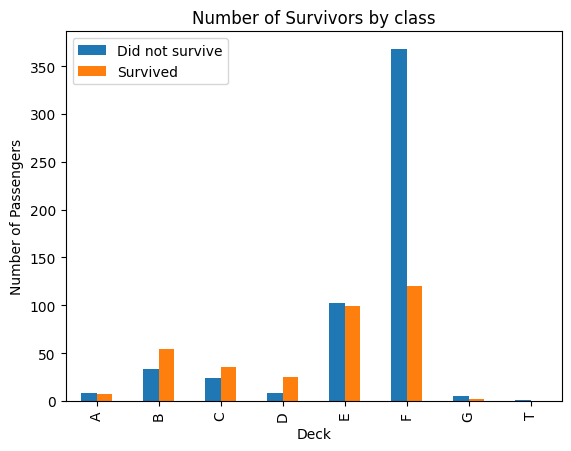

In [19]:
dataset.groupby(['Deck', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by class')
plt.legend(['Did not survive', 'Survived'])
plt.show()

Finally let's map the deck to a numerical encoding. 
This will make it easier to use this data for building prediciton models later. Generally you should map catagorical variables using one hot encoding to ensure the model doent infer an ordered relationship.

However, the deck letter actually does have an ordered relationship, that is to say what deck an individuals cabin was on the has a relationship to their survivability. Therefore it makes sense for the model to try and infer a relationship between being farther below deck and a higher likelyhood of dying on the ship. 

### Now cabin number which again has a relationship to the distance to the breach and therefore survival chances

In [20]:
def extract_cabin_number(cabin):
    if pd.notna(cabin):
        parts = cabin.split()
        if len(parts) > 0 and len(parts[0]) > 1:
            return int(parts[0][1:])
    return 60

In [21]:
dataset['Cabin_Number'] = dataset['Cabin'].apply(extract_cabin_number)

In [22]:
dataset.head(5)

Survived Pclass  \
PassengerId                        
1            Not Survived  Third   
2                Survived  First   
3                Survived  Third   
4                Survived  First   
5            Not Survived  Third   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked Deck  \
PassengerId                                                                
1                1      0         A/5 21171   7.2500   F81        S    F   
2                1      0          PC 17599  71.2833   C85        C    C   
3                0      0  STON/O2. 3101282   7.9250   F81        S    F   
4                1      0            113803  53.1000  C123        S    C   
5                0      0            373450   8.0500   F81        S    F   

             Cabin_Number  
PassengerId                
1                      81  
2                      85  
3                      81  
4                     123  
5                      81

## Now let's take a look at the names.

In [23]:
dataset['Name'].head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

As you can see it is difficult to extrat much from this data. One thing we may be able to extract is the titles. This may tell us something about the individual or their professions or marital status. For example women who are married willl be Mrs,
men in the army may be Capt. Major or Col and uperclass people may be Lady or Sir. This can be extracted from the name varaible using regular expressions

In [24]:
# Define a function to extract titles
def extract_title(name):
    match = re.search(r'(Mrs\.|Miss|Mr\.|Dr\.|Master\.|Ms\.|Sir\.|Rev\.|Capt\.|Col\.|Major\.|Mlle\.|Jonkheer\.|Lady\.|Don\.|Dona\.|Countess\.|Mme\.)', name)
    return match.group(0) if match else 'Other'

In [25]:
# Define a function to categorize titles
def categorize_title(title):
    if title in ['Lady.', 'Countess.', 'Mme.','Sir.', 'Jonkheer.', 'Don.', 'Dona.']:
        return 'Upper-class'
    elif title in ['Mrs.']:
        return 'Married Women'
    elif title in ['Miss', 'Mlle.', 'Ms.']:
        return 'Single Women'
    elif title in ['Mr.', 'Master.']:
        return 'Single Men'
    elif title in ['Dr.', 'Rev.','Capt.', 'Col.', 'Major.']:
        return 'Professionals'
    else:
        return 'Other'

In [26]:
dataset['Title_Category'] = dataset['Name'].apply(extract_title).apply(categorize_title)

### As we can see from the below plot, it appars that Married women were slightly more likely to survive than those who were not married, but again single men were much more likely to perish

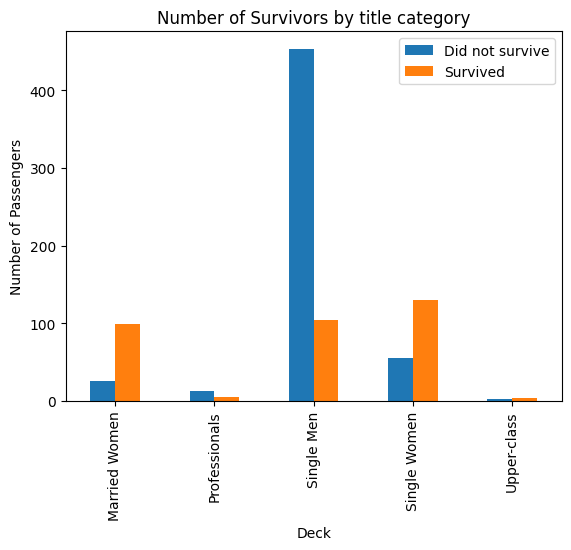

In [27]:
dataset.groupby(['Title_Category', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by title category')
plt.legend(['Did not survive', 'Survived'])
plt.show()

## Ticket ID

The ticket ID is not neceissarily unique, and can be shared by multiple people (for instnace if they were in a gorup). This may be a useful variable to model as well as those with others such as friends etc. may have had more chace of survival. 

In [28]:
dataset['Ticket_Count'] = dataset.groupby('Ticket')['Ticket'].transform('count')

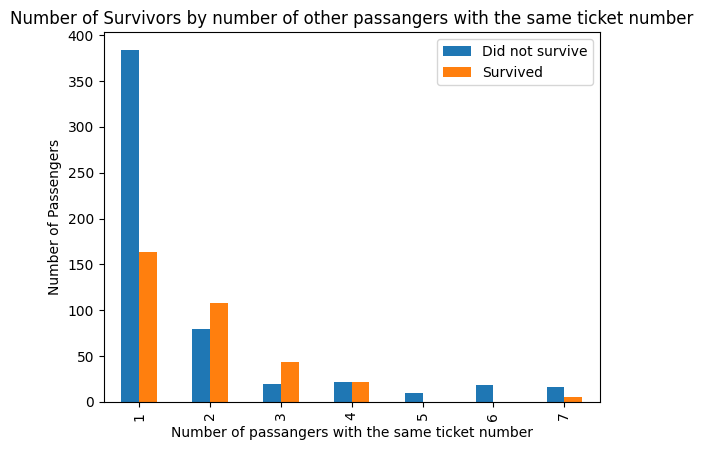

In [29]:
dataset.groupby(['Ticket_Count', 'Survived']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Number of passangers with the same ticket number')
plt.ylabel('Number of Passengers')
plt.title('Number of Survivors by number of other passangers with the same ticket number')
plt.legend(['Did not survive', 'Survived'])
plt.show()

# 3. Machine learning Modeling

## Preparing the dataset for model training

### Remove missing values

First let's check if there are any NA values in our database outstanding

In [30]:
dataset.isna().sum()

Survived            0
Pclass              0
Name                0
Sex                 0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            2
Deck                0
Cabin_Number        0
Title_Category      0
Ticket_Count        0
dtype: int64

We could fill these with the mean of the whole dataset, but we can actually be a bit more clever than that.

We can use a method called group based imputation to fill based on statistical properites of the specific groups. Specifically let's go based on the class, sex and title catagory. 

In [31]:
mean_age = dataset.groupby(['Pclass', 'Sex','Title_Category'])['Age'].transform('mean').astype(int)
dataset['Age'] = dataset['Age'].fillna(mean_age)

### Encoding catagorical variables

We one hot encode the catagorical varaibles of Sex, embarked location and title category, to ensure that the model does not infer any ordered relationship between them. 

In [32]:
dataset = pd.get_dummies(dataset, columns = ['Sex'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'])
dataset = pd.get_dummies(dataset, columns = ['Title_Category'])

In [33]:
dataset['Pclass'] = dataset['Pclass'].map({'First':1,'Second':2, "Third":3})
dataset['Survived'] = dataset['Survived'].map({'Not Survived':0, 'Survived':1})

For the deck we will use numerical encoding, as these do have an ordered relationship with regards to how deep into the ship the individuals room was. 

In [34]:
deck_encoding = {
                    'A':1,
                    'B':2,
                    'C':3,
                    'D':4,
                    'E':5,
                    'F':6,
                    'G':7,
                    'T':8
                    }
dataset['Deck'] = dataset['Deck'].map(deck_encoding)

Let's now remove the Non-encoded or non useful features

In [35]:
dataset = dataset.drop(columns=['Name','Ticket','Cabin'])

In [36]:
dataset.head()

Survived  Pclass   Age  SibSp  Parch     Fare  Deck  \
PassengerId                                                        
1                   0       3  22.0      1      0   7.2500     6   
2                   1       1  38.0      1      0  71.2833     3   
3                   1       3  26.0      0      0   7.9250     6   
4                   1       1  35.0      1      0  53.1000     3   
5                   0       3  35.0      0      0   8.0500     6   

             Cabin_Number  Ticket_Count  Sex_female  Sex_male  Embarked_C  \
PassengerId                                                                 
1                      81             1       False      True       False   
2                      85             1        True     False        True   
3                      81             1        True     False       False   
4                     123             2        True     False       False   
5                      81             1       False      True       False   

             Embarked_Q  Embarked_S  Title_Category_Married Women  \
PassengerId                                                         
1                 False        True                         False   
2                 False       False                          True   
3                 False        True                         False   
4                 False        True                          True   
5                 False        True                         False   

             Title_Category_Professionals  Title_Category_Single Men  \
PassengerId                                                            
1                                   False                       True   
2                                   False                      False   
3                                   False                      False   
4                                   False                      False   
5                                   False                       True   

             Title_Category_Single Women  Title_Category_Upper-class  
PassengerId                                                           
1                                  False                       False  
2                                  False                       False  
3                                   True                       False  
4                                  False                       False  
5                                  False                       False

## Lets train an XGBoost ML Model to predict who survived:

In [37]:

import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
import xgboost as xgb


In [38]:
# Assuming df is your DataFrame
# Features and target variable
X = dataset.drop(columns=['Survived'])
y = dataset['Survived']

In [39]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier()


# Define scoring metrics
scoring = {
'accuracy': make_scorer(accuracy_score),
'precision': make_scorer(precision_score),
'recall': make_scorer(recall_score)
}

# Perform cross-validation
cv = StratifiedKFold(n_splits=5)
accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
recall = cross_val_score(model, X, y, cv=cv, scoring='recall')

print(f"Accuracy: {accuracy.mean()}")
print(f"Precision: {precision.mean()}")
print(f"Recall: {recall.mean()}")


Accuracy: 0.8238089259933463
Precision: 0.7864151686574772
Recall: 0.7426257459505541


### Let's take a look at which features the model finds the most important

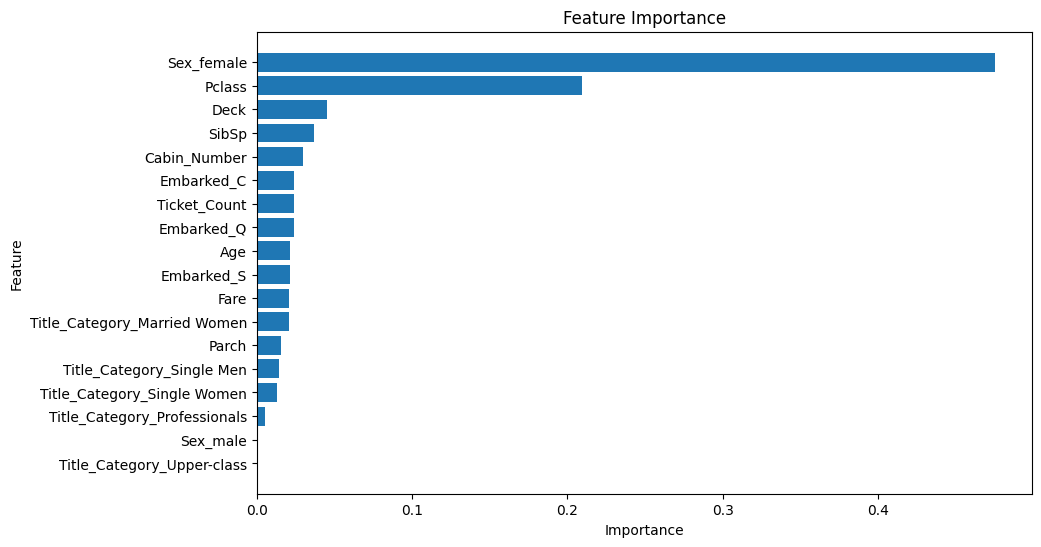

                         Feature  Importance
8                     Sex_female    0.475013
0                         Pclass    0.209540
5                           Deck    0.045116
2                          SibSp    0.037061
6                   Cabin_Number    0.029553
10                    Embarked_C    0.024119
7                   Ticket_Count    0.023980
11                    Embarked_Q    0.023831
1                            Age    0.021592
12                    Embarked_S    0.021224
4                           Fare    0.020538
13  Title_Category_Married Women    0.020533
3                          Parch    0.015485
15     Title_Category_Single Men    0.014173
16   Title_Category_Single Women    0.012868
14  Title_Category_Professionals    0.005372
9                       Sex_male    0.000000
17    Title_Category_Upper-class    0.000000


In [40]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Features and target variable
X = dataset.drop(columns=['Survived'])
y = dataset['Survived']

# Initialize and fit the XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X, y)

# Get feature importance
importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)


## Let's evaluate the model on the holdout dataset

First let's simlify the data cleaning process into a single method named prepare_dataset. 

In [41]:
def prepare_dataset(dataset):
    ### Define the average cabins 
    average_cabins = {1: 'B30',2: 'E60', 3: 'F81'}
    
    ### Clean cabin data
    dataset['Cabin'] = dataset.apply(lambda row: average_cabins[row['Pclass']] if pd.isna(row['Cabin']) else row['Cabin'], axis=1)
    dataset['Cabin'] = dataset['Cabin'].apply(extract_cabin_clean)
    
    ### Get the Deck and cabin number
    dataset['Deck'] = dataset['Cabin'].apply(lambda x: x[0] if pd.notna(x) else pd.NA)
    dataset['Cabin_Number'] = dataset['Cabin'].apply(extract_cabin_number)

    
    ## Extract the title category
    dataset['Title_Category'] = dataset['Name'].apply(extract_title).apply(categorize_title)
    
    dataset['Ticket_Count'] = dataset.groupby('Ticket')['Ticket'].transform('count')

    mean_age = dataset.groupby(['Pclass', 'Sex','Title_Category'])['Age'].transform('mean').astype(int)
    dataset['Age'] = dataset['Age'].fillna(mean_age)
    
    
    ### One hot encode catagorical data
    dataset = pd.get_dummies(dataset, columns = ['Sex'])
    dataset = pd.get_dummies(dataset, columns = ['Embarked'])
    dataset = pd.get_dummies(dataset, columns = ['Title_Category'])
    
    ### Encode the deck
    deck_encoding = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8}
    dataset['Deck'] = dataset['Deck'].map(deck_encoding)
    
    #dataset = dataset.drop(columns=['Name','Ticket','Cabin'])

    return dataset

### Now let's reload both datasets and process them

In [42]:
train_dataset =  pd.read_csv("titanic\\train.csv", index_col ="PassengerId")
test_dataset =  pd.read_csv("titanic\\test.csv", index_col ="PassengerId")

In [43]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset)


In [44]:
test_dataset

Pclass                                          Name   Age  \
PassengerId                                                               
892               3                              Kelly, Mr. James  34.5   
893               3              Wilkes, Mrs. James (Ellen Needs)  47.0   
894               2                     Myles, Mr. Thomas Francis  62.0   
895               3                              Wirz, Mr. Albert  27.0   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  22.0   
...             ...                                           ...   ...   
1305              3                            Spector, Mr. Woolf  24.0   
1306              1                  Oliva y Ocana, Dona. Fermina  39.0   
1307              3                  Saether, Mr. Simon Sivertsen  38.5   
1308              3                           Ware, Mr. Frederick  24.0   
1309              3                      Peter, Master. Michael J  24.0   

             SibSp  Parch              Ticket      Fare Cabin  Deck  \
PassengerId                                                           
892              0      0              330911    7.8292   F81     6   
893              1      0              363272    7.0000   F81     6   
894              0      0              240276    9.6875   E60     5   
895              0      0              315154    8.6625   F81     6   
896              1      1             3101298   12.2875   F81     6   
...            ...    ...                 ...       ...   ...   ...   
1305             0      0           A.5. 3236    8.0500   F81     6   
1306             0      0            PC 17758  108.9000  C105     3   
1307             0      0  SOTON/O.Q. 3101262    7.2500   F81     6   
1308             0      0              359309    8.0500   F81     6   
1309             1      1                2668   22.3583   F81     6   

             Cabin_Number  ...  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
PassengerId                ...                                                 
892                    81  ...       False      True       False        True   
893                    81  ...        True     False       False       False   
894                    60  ...       False      True       False        True   
895                    81  ...       False      True       False       False   
896                    81  ...        True     False       False       False   
...                   ...  ...         ...       ...         ...         ...   
1305                   81  ...       False      True       False       False   
1306                  105  ...        True     False        True       False   
1307                   81  ...       False      True       False       False   
1308                   81  ...       False      True       False       False   
1309                   81  ...       False      True        True       False   

             Embarked_S  Title_Category_Married Women  \
PassengerId                                             
892               False                         False   
893                True                          True   
894               False                         False   
895                True                         False   
896                True                          True   
...                 ...                           ...   
1305               True                         False   
1306              False                         False   
1307               True                         False   
1308               True                         False   
1309              False                         False   

             Title_Category_Professionals  Title_Category_Single Men  \
PassengerId                                                            
892                                 False                       True   
893                                 False                      False   
894                                 False 